In [2]:
### imports ###
import pygmt
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.image as mpimg 
from mpl_toolkits.basemap import Basemap

import pandas as pd

%matplotlib inline
%matplotlib widget


# time series plot
import xarray as xr
xr.set_options(keep_attrs=True)

import datetime

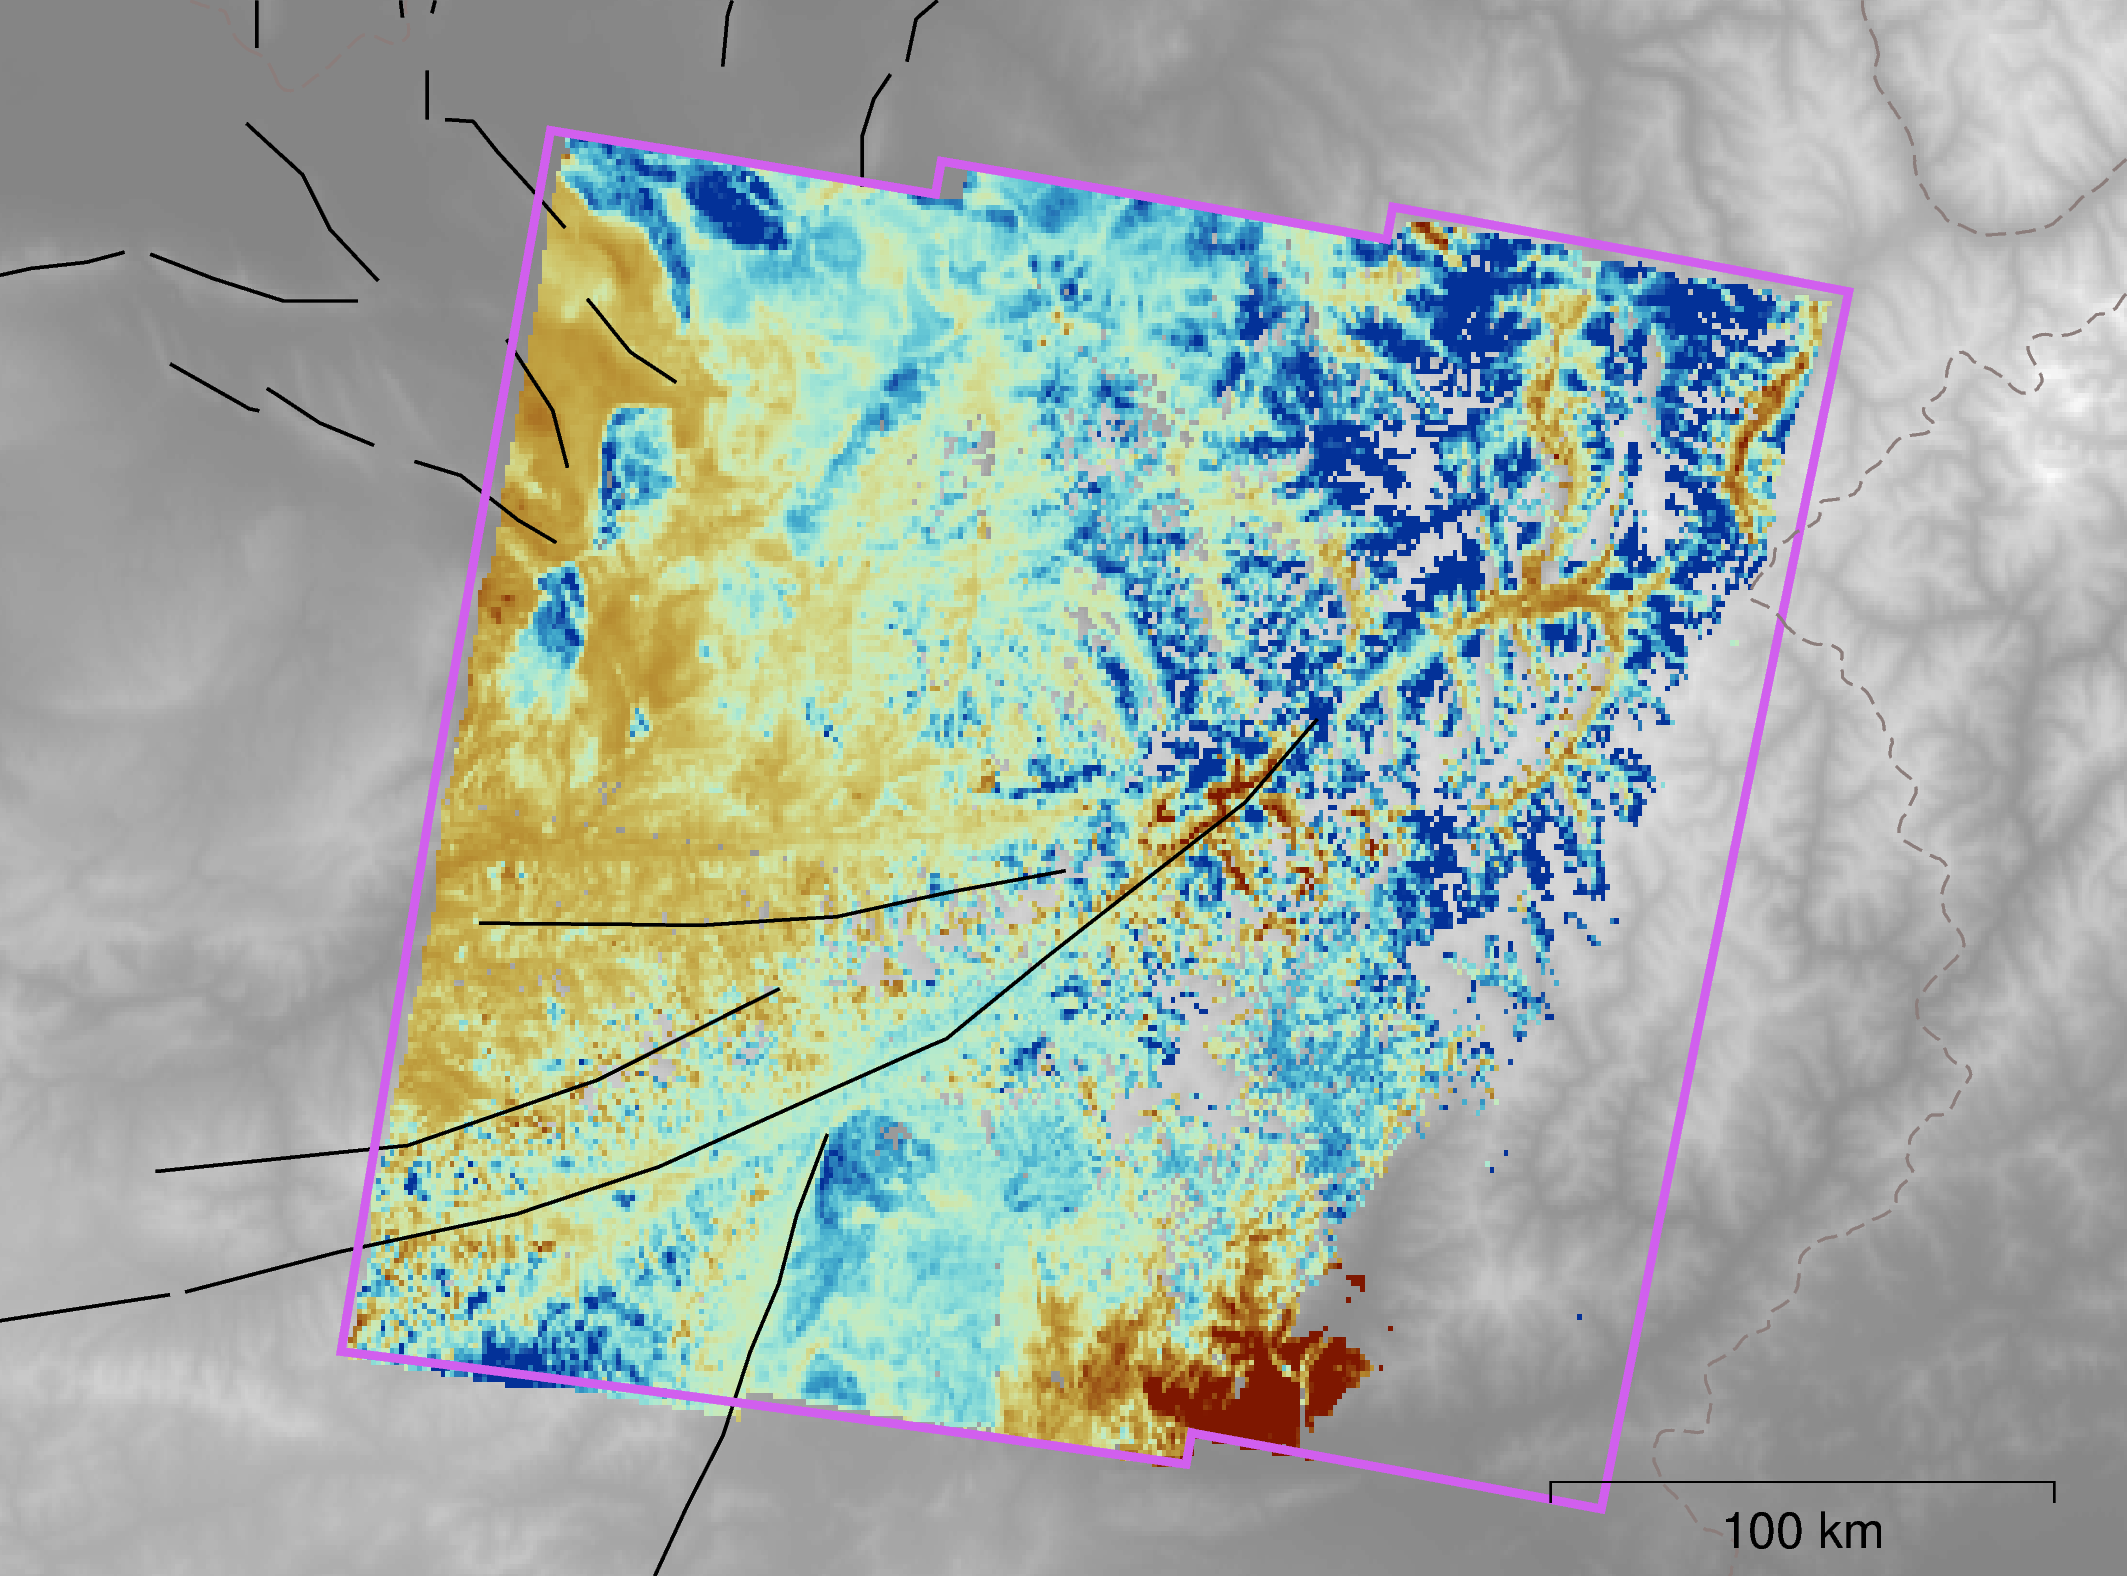

In [3]:
### plotting InSAR velocities on a PyGMT basemap ###

###########################################
## Specify coords
# llcrnrlat,llcrnrlon, urcrnrlat, urcrnrlon
# are the lat/lon values of the lower left and upper right corners of the map

llcrnrlon=67.4 # lower left corner longitude 
llcrnrlat=34.3 # lower left corner latitude
urcrnrlon=72 # upper right corner longitude
urcrnrlat=37.08 # upper right corner latitude


proj_scale_w = 18 # specify projection scale (width)
proj_scale_unit = "c" # choose between c (cm) and i (inches)
# 17.78c = 7i


InSAR_NetCDF = "078D_05435_131313.nc"
frame = "078D_05435_131313"

mindate = datetime.date(2016,3,9)
maxdate = datetime.date(2024,7,10)

lon = 70
lat = 36
###########################################

centerlon = (urcrnrlon - llcrnrlon)/2 + llcrnrlon # midpoints
centerlat = (urcrnrlat - llcrnrlat)/2 + llcrnrlat
region=[llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat]

fig = pygmt.Figure()
pygmt.config(FONT="Helvetica",\
             FONT_ANNOT_PRIMARY ="12p", FONT_LABEL = "11p")
fig.coast(region=region,\
          projection="M%s/%s/%s%s" % (centerlon, urcrnrlat, proj_scale_w, proj_scale_unit),\
          water="white", land="grey", shorelines="1/0.5p")


## loading topography
grid = pygmt.datasets.load_earth_relief("30s", registration="gridline", region=region)
fig.grdimage(grid=grid, cmap="bin/seabluelandgrey.cpt")


## plotting velocity
pygmt.makecpt(output="bin/roma_InSAR", series=[-15, 15], reverse=True, cmap="roma")
              # redefine scale + inverse
              # stored in local sesh

ncarray = xr.open_dataset("bin/" + InSAR_NetCDF)
vel = ncarray["vel"]
mskd = ncarray["mask"]
vel_mskd = vel * mskd
vel_mskd = vel_mskd.where(vel_mskd != 0, np.nan)

fig.grdimage(grid=vel_mskd, nan_transparent = True, transparency = 0, cmap="bin/roma_InSAR")



## plotting faults (after Styron et al. (2010) and Taylor and An Yin (2009))
fig.plot(data="bin/HimaTibetMap.gmt", pen=f"0.7p,black") # all faults



## plotting bounding polygon (for descending frame 078D_05435_131313)
fig.plot(data="bin/078D_05435_131313-poly.txt", pen=f"2p,mediumorchid2") # 078D_05435_131313


fig.coast(map_scale="g71.3/34.45+w100k", shorelines="1/0.5p", borders="1/0.6p, mistyrose4,-")

fig.show()
fig.savefig("078D_05435_131313.png")

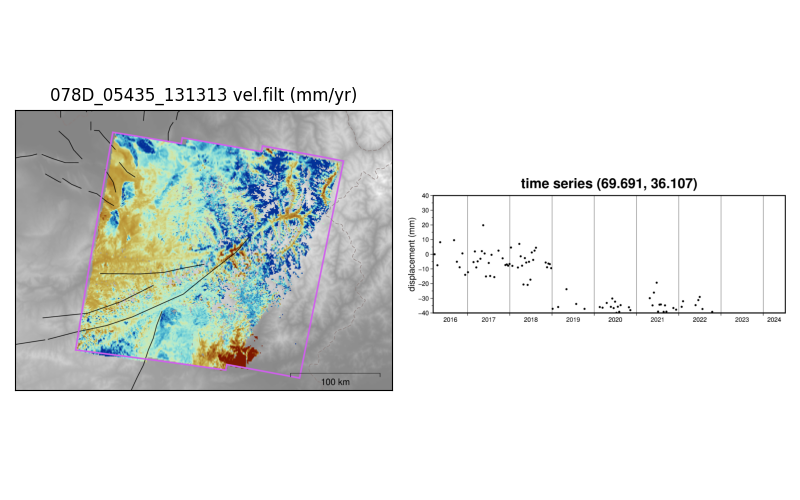

In [4]:
### modifying mercator_png for an interactive time-series plot ###

png_path = "078D_05435_131313.png"
spam_path = "time_series_spam.png"


img = Image.open(png_path)
width, height = img.size # (width,height) tuple in pixels
DPI_horz, DPI_vert = img.info.get('dpi')

assert DPI_horz == DPI_vert

fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(121)

# creating matplotlib basemap for overlay
m = Basemap(projection='merc', resolution='i',\
                        llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat,\
                        llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon)

m.drawcoastlines() # draws coastlines on matplotlib. this makes sure that everything is aligned

'''
# plotting parallels and meridians, annotating axis
grid_freq = 1
parallels = np.arange(-90, 90, grid_freq)
meridians = np.arange(-180, 180, grid_freq)
m.drawparallels(parallels, labels=[1,0,0,0], fontsize=12, linewidth=0.5) # label parallels on right and top
m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=12, linewidth=0.5) # meridians on bottom and left
'''

img = mpimg.imread(png_path)
m.imshow(img, origin='upper')

ax1.set_title(frame+" vel.filt (mm/yr)")


ax2 = fig.add_subplot(122)
ax2.axis('off')
plt.tight_layout()

img = mpimg.imread(spam_path)
ax2.imshow(img, origin='upper')


def pos_to_lonlat(x, y):
  lon, lat = m(x, y, inverse=True)
  return lon, lat

pos = [] # in format [[None, None], [x, y], [x, y], ...]
lonlat = []

ds = xr.open_dataset("bin/"+InSAR_NetCDF)
time_ds=ds["time"].values
time = pd.to_datetime(time_ds)

cum=ds["cum"]

def onclick(event):
  pos.append([event.xdata, event.ydata])

  lon, lat = pos_to_lonlat(pos[-1][0], pos[-1][1]) # pos[-1] represents last click (list with x, y)
  lonlat.append([lon, lat]) # converts x y to lon lat and appends

  # code below shows how gmt_png can be modified for an interactive time series plot
  # alternatively retrive lon lat using coords_from_figure(ax1)
  # ax1.set_title(f'Click {len(pos)}: {lon}, {lat}') 
  cum_point = cum.sel(lon=lon, lat=lat, method='nearest')

  fig = pygmt.Figure()

  fig.plot(
      projection="X18c/6c",
      region=[mindate, maxdate, -40, 40],
      frame=["+t time series (%.3f, %.3f)" % (lon, lat),\
              "xa1Yfg1Y", "ya10f5+ldisplacement (mm)"],
      x=time,
      y=cum_point,
      style="c0.1c",
      fill="black"
  )

  fig.basemap(frame=True)
  fig.savefig(spam_path)

  img = mpimg.imread(spam_path)
  ax2.imshow(img, origin='upper')




cid=fig.canvas.mpl_connect('button_press_event', onclick)